In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from pytorch_model_summary import summary

In [2]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode="train", transforms=None):
        digits = load_digits()
        if mode == "train":
            self.data = digits.data[:1000].astype(np.float32)
        elif mode == "val":
            self.data = digits.data[1000:1350].astype(np.float32)
        else:
            self.data = digits.data[1350:].astype(np.float32)

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample

In [3]:
data = Digits()

In [4]:
data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.],
      dtype=float32)

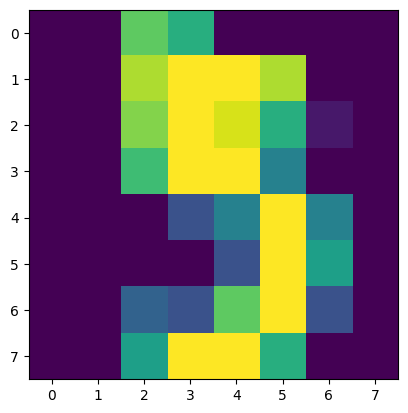

In [5]:
plt.imshow(data[5].reshape((8, 8)))

In [6]:
EPS = 1.0e-5


def log_categorical(x, p, num_classes=256, reduction=None, dim=None):
    x_one_hot = F.one_hot(x.long(), num_classes=num_classes)
    log_p = x_one_hot * torch.log(torch.clamp(p, EPS, 1.0 - EPS))
    if reduction == "avg":
        return torch.mean(log_p, dim)
    elif reduction == "sum":
        return torch.sum(log_p, dim)
    else:
        return log_p

In [ ]:
class ARM(nn.Module):
    def __init__(self, net, D=2, num_vals=256):
        super().__init__()
        self.net = net
        self.num_vals = num_vals
        self.D = D

    def f(self, x):
        h = self.net(x.unsqueeze(1))
        h = h.permute(0, 2, 1)
        p = torch.softmax(h, 2)
        return p

    def forward(self, x, reduction='avg'):
        if reduction == 'avg':
            return -(self.log_prob(x).mean())
        elif reduction == "sum":
            return -(self.log_prob(x).sum())
        else:
            raise ValueError('reduction could be either "avg" or "sum".')

    def log_prob(self, x):
        mu_d = self.f(x)
        log_p = log_categorical(
            x, mu_d, num_classes=self.num_vals, reduction="sum", dim=-1
        ).sum(-1)

        return log_p

    def sample(self, batch_size):
        x_new = torch.zeros((batch_size, self.D))

        for d in range(self.D):
            p = self.f(x_new)
            x_new_d = torch.multinomial(p[:, d, :], num_samples=1)
            x_new[:, d] = x_new_d[:, 0]

        return x_new

In [8]:
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + ".model")

    model_best.eval()
    loss = 0.0
    N = 0.0
    for indx_batch, test_batch in enumerate(test_loader):
        loss_t = model_best.forward(test_batch, reduction="sum")
        loss = loss + loss_t.item()
        N = N + test_batch.shape[0]
    loss = loss / N

    if epoch is None:
        print(f"FINAL LOSS: nll={loss}")
    else:
        print(f"Epoch: {epoch}, val nll={loss}")

    return loss


def samples_real(name, test_loader):
    # REAL-------
    num_x = 4
    num_y = 4
    x = next(iter(test_loader)).detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap="gray")
        ax.axis("off")

    plt.savefig(name + "_real_images.pdf", bbox_inches="tight")
    plt.close()


def samples_generated(name, data_loader, extra_name=""):
    x = next(iter(data_loader)).detach().numpy()

    # GENERATIONS-------
    model_best = torch.load(name + ".model")
    model_best.eval()

    num_x = 4
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap="gray")
        ax.axis("off")

    plt.savefig(name + "_generated_images" + extra_name + ".pdf", bbox_inches="tight")
    plt.close()


def plot_curve(name, nll_val):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth="3")
    plt.xlabel("epochs")
    plt.ylabel("nll")
    plt.savefig(name + "_nll_val_curve.pdf", bbox_inches="tight")
    plt.close()

In [9]:
def training(
    name, max_patience, num_epochs, model, optimizer, training_loader, val_loader
):
    nll_val = []
    best_nll = 1000.0
    patience = 0

    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train()
        for indx_batch, batch in enumerate(training_loader):
            if hasattr(model, "dequantization"):
                if model.dequantization:
                    batch = batch + torch.rand(batch.shape)
            loss = model.forward(batch)

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        # Validation
        loss_val = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_val)  # save for plotting

        if e == 0:
            print("saved!")
            torch.save(model, name + ".model")
            best_nll = loss_val
        else:
            if loss_val < best_nll:
                print("saved!")
                torch.save(model, name + ".model")
                best_nll = loss_val
                patience = 0

                samples_generated(name, val_loader, extra_name="_epoch_" + str(e))
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    nll_val = np.asarray(nll_val)

    return nll_val

In [10]:
train_data = Digits(mode="train")
val_data = Digits(mode="val")
test_data = Digits(mode="test")

training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

result_dir = "results/"
if not (os.path.exists(result_dir)):
    os.mkdir(result_dir)
name = "arm"

In [11]:
D = 64  # input dimension
M = 256  # the number of neurons in scale (s) and translation (t) nets

lr = 1e-3  # learning rate
num_epochs = 10  # max. number of epochs
max_patience = 20  # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

In [12]:
class CausalConv1d(nn.Module):
    """
    A causal 1D convolution.
    """

    def __init__(
        self, in_channels, out_channels, kernel_size, dilation, A=False, **kwargs
    ):
        super(CausalConv1d, self).__init__()

        # attributes:
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.A = A

        self.padding = (kernel_size - 1) * dilation + A * 1

        # module:
        self.conv1d = torch.nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            stride=1,
            padding=0,
            dilation=dilation,
            **kwargs
        )

    def forward(self, x):
        x = torch.nn.functional.pad(x, (self.padding, 0))
        conv1d_out = self.conv1d(x)
        if self.A:
            return conv1d_out[:, :, :-1]
        else:
            return conv1d_out

In [13]:
likelihood_type = "categorical"

num_vals = 17

kernel = 7

net = nn.Sequential(
    CausalConv1d(
        in_channels=1, out_channels=M, dilation=1, kernel_size=kernel, A=True, bias=True
    ),
    nn.LeakyReLU(),
    CausalConv1d(
        in_channels=M,
        out_channels=M,
        dilation=1,
        kernel_size=kernel,
        A=False,
        bias=True,
    ),
    nn.LeakyReLU(),
    CausalConv1d(
        in_channels=M,
        out_channels=M,
        dilation=1,
        kernel_size=kernel,
        A=False,
        bias=True,
    ),
    nn.LeakyReLU(),
    CausalConv1d(
        in_channels=M,
        out_channels=num_vals,
        dilation=1,
        kernel_size=kernel,
        A=False,
        bias=True,
    ),
)

model = ARM(net, D=D, num_vals=num_vals)

# Print the summary (like in Keras)
print(summary(model, torch.zeros(1, 64), show_input=False, show_hierarchical=False))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
    CausalConv1d-1        [1, 256, 64]           2,048           2,048
       LeakyReLU-2        [1, 256, 64]               0               0
    CausalConv1d-3        [1, 256, 64]         459,008         459,008
       LeakyReLU-4        [1, 256, 64]               0               0
    CausalConv1d-5        [1, 256, 64]         459,008         459,008
       LeakyReLU-6        [1, 256, 64]               0               0
    CausalConv1d-7         [1, 17, 64]          30,481          30,481
Total params: 950,545
Trainable params: 950,545
Non-trainable params: 0
-----------------------------------------------------------------------


In [14]:
optimizer = torch.optim.Adamax(
    [p for p in model.parameters() if p.requires_grad == True], lr=lr
)

In [15]:
nll_val = training(
    name=result_dir + name,
    max_patience=max_patience,
    num_epochs=num_epochs,
    model=model,
    optimizer=optimizer,
    training_loader=training_loader,
    val_loader=val_loader,
)

Epoch: 0, val nll=117.35728166852678
saved!
Epoch: 1, val nll=112.13411272321429
saved!
Epoch: 2, val nll=109.97497488839285
saved!
Epoch: 3, val nll=108.04765485491072
saved!
Epoch: 4, val nll=106.36564313616071
saved!
Epoch: 5, val nll=104.24338309151786
saved!
Epoch: 6, val nll=101.79314732142858
saved!
Epoch: 7, val nll=99.94033761160715
saved!
Epoch: 8, val nll=97.8099462890625
saved!
Epoch: 9, val nll=96.71830845424107
saved!


In [16]:
test_loss = evaluation(name=result_dir + name, test_loader=test_loader)
f = open(result_dir + name + "_test_loss.txt", "w")
f.write(str(test_loss))
f.close()

samples_real(result_dir + name, test_loader)

plot_curve(result_dir + name, nll_val)

FINAL LOSS: nll=93.53871950153803
